In [16]:
#Part 1: Data Preprocessing
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define constants
IMG_SIZE = 150  # Resize images to this dimension
BATCH_SIZE = 32
SEED = 42
VALIDATION_SPLIT = 0.2  # 20% of training data for validation

# Path to Intel Image Classification Dataset
train_dir = 'intel_image_dataset/seg_train/seg_train'
test_dir = 'intel_image_dataset/seg_test/seg_test'

# Categories in the Intel dataset
categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [17]:
# 1. EXPLORATORY DATA ANALYSIS (EDA)
def perform_eda(train_dir, test_dir):
    """Perform exploratory data analysis on the dataset"""
    print("=" * 50)
    print("EXPLORATORY DATA ANALYSIS")
    print("=" * 50)
    
    # Calculate and visualize class distribution
    train_counts = {}
    test_counts = {}
    
    # Count training images per class
    for category in categories:
        path = os.path.join(train_dir, category)
        if os.path.exists(path):
            count = len(os.listdir(path))
            train_counts[category] = count
    
    # Count test images per class
    for category in categories:
        path = os.path.join(test_dir, category)
        if os.path.exists(path):
            count = len(os.listdir(path))
            test_counts[category] = count
    
    # Display class distribution statistics
    print("\nClass Distribution:")
    for category in categories:
        train_count = train_counts.get(category, 0)
        test_count = test_counts.get(category, 0)
        print(f"{category}: {train_count} training images, {test_count} test images")
    
    total_train = sum(train_counts.values())
    total_test = sum(test_counts.values())
    print(f"\nTotal: {total_train} training images, {total_test} test images")
    
    # Plot class distribution
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
    plt.title('Training Set Class Distribution')
    plt.xticks(rotation=45)
    plt.ylabel('Number of Images')
    
    plt.subplot(1, 2, 2)
    sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()))
    plt.title('Test Set Class Distribution')
    plt.xticks(rotation=45)
    plt.ylabel('Number of Images')
    
    plt.tight_layout()
    plt.show()
    
    # Sample images from each class
    plt.figure(figsize=(15, 10))
    for i, category in enumerate(categories):
        path = os.path.join(train_dir, category)
        if os.path.exists(path):
            img_files = os.listdir(path)
            if img_files:
                img_path = os.path.join(path, img_files[0])
                img = Image.open(img_path)
                plt.subplot(2, 3, i+1)
                plt.imshow(img)
                plt.title(f"{category}")
                plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return train_counts, test_counts, total_train, total_test



In [18]:
# 2. DATA AUGMENTATION AND GENERATORS
def create_data_generators(validation_split=VALIDATION_SPLIT):
    """Create data generators with augmentation and validation split"""
    # Training data generator with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=validation_split  # Split for validation
    )
    
    # Test data generator (only rescaling)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Flow from directory for training
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        classes=categories,
        seed=SEED,
        subset='training'  # Specify training subset
    )
    
    # Flow from directory for validation
    validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        classes=categories,
        seed=SEED,
        subset='validation'  # Specify validation subset
    )
    
    # Flow from directory for testing
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        classes=categories,
        seed=SEED,
        shuffle=False
    )
    
    return train_generator, validation_generator, test_generator



In [19]:
# 3. VISUALIZE AUGMENTED IMAGES
def plot_augmented_images(generator, num_images=5):
    """Visualize augmented images from generator"""
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        batch = next(generator)
        img = batch[0][0]  # First image in batch
        label_idx = batch[1][0].argmax()  # Get class index from one-hot encoded label
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f"Class: {categories[label_idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()



EXPLORATORY DATA ANALYSIS

Class Distribution:
buildings: 2191 training images, 437 test images
forest: 2271 training images, 474 test images
glacier: 2404 training images, 553 test images
mountain: 2512 training images, 525 test images
sea: 2274 training images, 510 test images
street: 2382 training images, 501 test images

Total: 14034 training images, 3000 test images


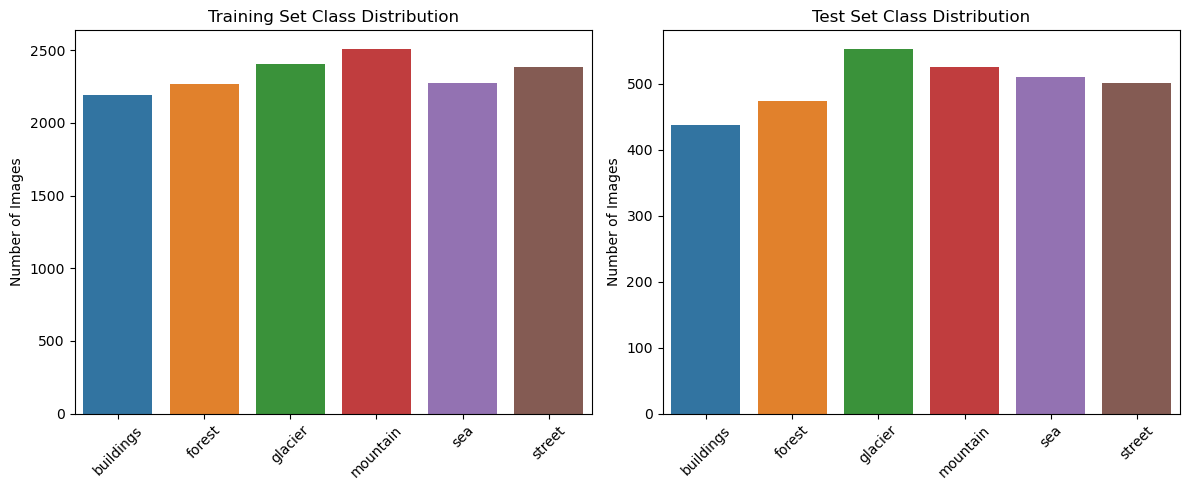

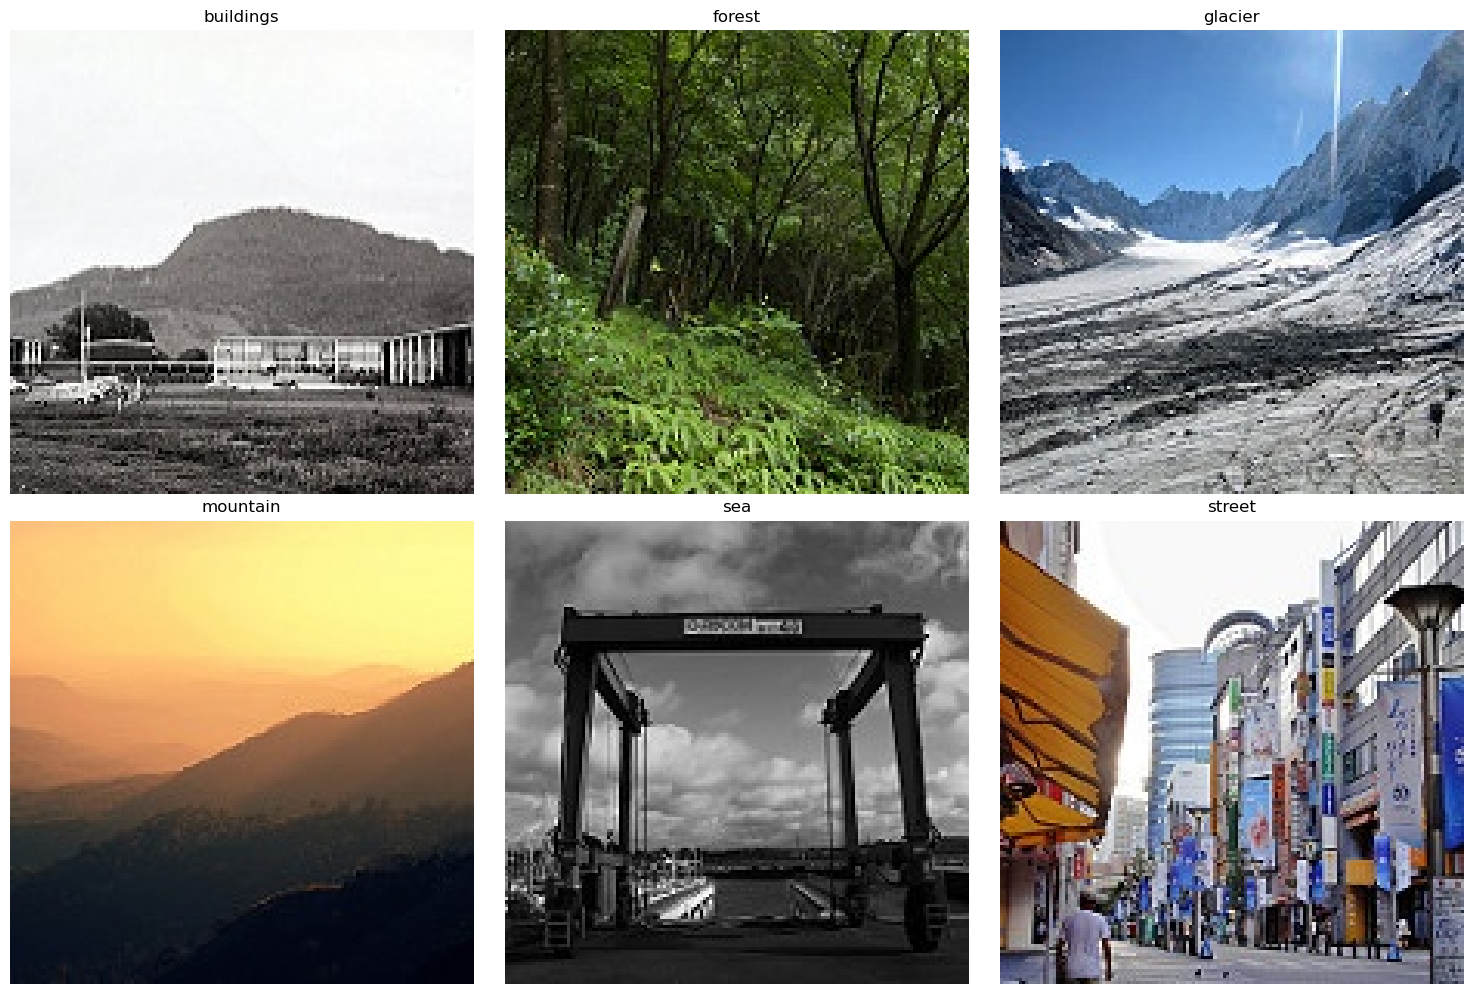


Creating data generators for training, validation, and testing...
Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 11230 training images
Found 2804 validation images
Found 3000 test images
Steps per epoch: 350
Validation steps: 87

Visualizing augmented training images...
Found 14034 images belonging to 6 classes.


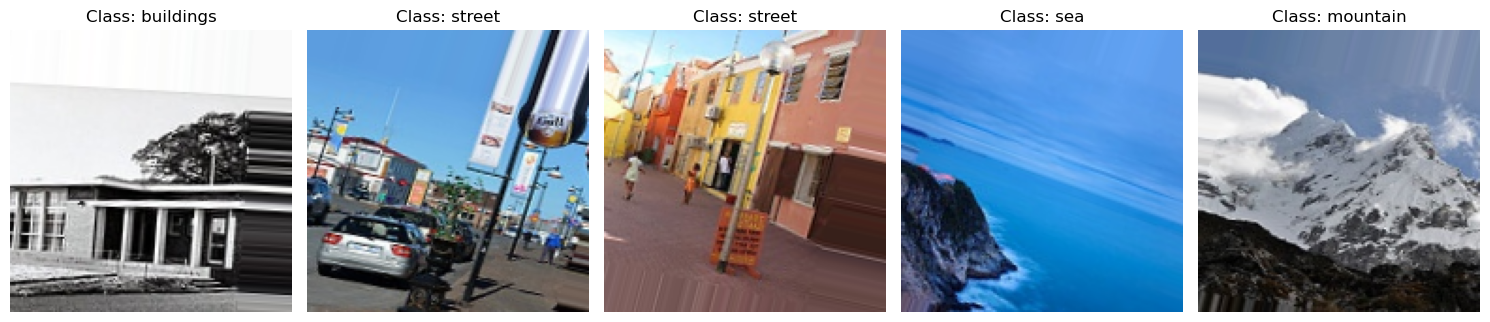


PREPROCESSING SUMMARY
• Dataset loaded and explored: 17034 total images
• Images resized to: 150×150 pixels
• Pixel values normalized to range [0,1]
• Data augmentation applied: rotation, shift, shear, zoom, flip
• Dataset split: 11230 training, 2804 validation, 3000 test images
• Class balancing verified
• Data prepared as generators for efficient memory usage

Preprocessing completed successfully!


In [20]:
# Main execution
try:
    # Run EDA first
    train_counts, test_counts, total_train, total_test = perform_eda(train_dir, test_dir)
    
    # Create data generators for training, validation, and testing
    print("\nCreating data generators for training, validation, and testing...")
    train_generator, validation_generator, test_generator = create_data_generators()
    
    print(f"Found {train_generator.samples} training images")
    print(f"Found {validation_generator.samples} validation images")
    print(f"Found {test_generator.samples} test images")
    
    # Calculate steps per epoch
    steps_per_epoch = train_generator.samples // train_generator.batch_size
    validation_steps = validation_generator.samples // validation_generator.batch_size
    
    print(f"Steps per epoch: {steps_per_epoch}")
    print(f"Validation steps: {validation_steps}")
    
    # Visualize some augmented images
    print("\nVisualizing augmented training images...")
    # Create a generator just for visualization
    vis_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Create a generator with just one image for visualization
    vis_generator = vis_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=1,
        class_mode='categorical',
        classes=categories,
        seed=SEED
    )
    
    plot_augmented_images(vis_generator)
    
    # Summary section
    print("\n" + "=" * 50)
    print("PREPROCESSING SUMMARY")
    print("=" * 50)
    print(f"• Dataset loaded and explored: {total_train + total_test} total images")
    print(f"• Images resized to: {IMG_SIZE}×{IMG_SIZE} pixels")
    print(f"• Pixel values normalized to range [0,1]")
    print(f"• Data augmentation applied: rotation, shift, shear, zoom, flip")
    print(f"• Dataset split: {train_generator.samples} training, {validation_generator.samples} validation, {test_generator.samples} test images")
    print(f"• Class balancing verified")
    print(f"• Data prepared as generators for efficient memory usage")
    print("=" * 50)
    
    print("\nPreprocessing completed successfully!")
    
except Exception as e:
    print(f"Error in preprocessing: {e}")

In [21]:
# Part 2: Train and Evaluate Image Classification Model
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam

# Constants 
IMG_SIZE = 150
BATCH_SIZE = 35
NUM_CLASSES = 6
EPOCHS = 25
LEARNING_RATE = 0.001
MODEL_ARCHITECTURE = 'mobilenet'  # options: 'mobilenet', 'resnet', 'efficientnet', 'custom'
OUTPUT_DIR = 'model_output'

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)



In [22]:
# Use data from previous step (train_generator, validation_generator, test_generator)

# 1. BUILD CNN MODEL
def build_model(architecture=MODEL_ARCHITECTURE):
    """Build a CNN model based on specified architecture"""
    
    print(f"Building {architecture} model...")
    
    if architecture == 'mobilenet':
        # MobileNetV2-based model
        base_model = MobileNetV2(
            input_shape=(IMG_SIZE, IMG_SIZE, 3),
            include_top=False,
            weights='imagenet'
        )
        
        # Freeze the base model
        base_model.trainable = False
        
        # Add custom layers on top
        inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
        x = base_model(inputs, training=False)
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.2)(x)
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(NUM_CLASSES, activation='softmax')(x)
        
        model = Model(inputs=inputs, outputs=outputs)
        
    elif architecture == 'resnet':
        # ResNet50-based model
        base_model = ResNet50(
            input_shape=(IMG_SIZE, IMG_SIZE, 3),
            include_top=False,
            weights='imagenet'
        )
        
        # Freeze the base model
        base_model.trainable = False
        
        # Add custom layers on top
        inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
        x = base_model(inputs, training=False)
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.3)(x)
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.4)(x)
        outputs = Dense(NUM_CLASSES, activation='softmax')(x)
        
        model = Model(inputs=inputs, outputs=outputs)
        
    elif architecture == 'efficientnet':
        # EfficientNetB0-based model
        base_model = EfficientNetB0(
            input_shape=(IMG_SIZE, IMG_SIZE, 3),
            include_top=False,
            weights='imagenet'
        )
        
        # Freeze the base model
        base_model.trainable = False
        
        # Add custom layers on top
        inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
        x = base_model(inputs, training=False)
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.2)(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(NUM_CLASSES, activation='softmax')(x)
        
        model = Model(inputs=inputs, outputs=outputs)
        
    else:  # custom CNN
        # Custom CNN architecture
        model = Sequential([
            # First convolutional block
            Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            Dropout(0.25),
            
            # Second convolutional block
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            Dropout(0.25),
            
            # Third convolutional block
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            Dropout(0.25),
            
            # Fully connected layers
            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(NUM_CLASSES, activation='softmax')
        ])
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print(f"Model built successfully!")
    model.summary()
    return model



In [23]:
# 2. CALLBACKS FOR TRAINING OPTIMIZATION
def create_callbacks():
    """Create callbacks for model training optimization"""
    
    # Create unique run name based on timestamp
    run_name = f"{MODEL_ARCHITECTURE}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    
    # Model checkpoint to save best model
    checkpoint_path = os.path.join(OUTPUT_DIR, f"{run_name}_best_model.h5")
    model_checkpoint = ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    
    # Learning rate adjusting
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
    
    # TensorBoard logging
    log_dir = os.path.join(OUTPUT_DIR, 'logs', run_name)
    tensorboard = TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,
        write_graph=True,
        update_freq='epoch'
    )
    
    return [early_stopping, model_checkpoint, reduce_lr, tensorboard]



In [24]:
# 3. TRAIN MODEL
def train_model(model, train_generator, validation_generator, epochs=EPOCHS):
    """Train the model with training and validation data"""
    
    print(f"Training {MODEL_ARCHITECTURE} model for {epochs} epochs...")
    
    # Get callbacks
    callbacks = create_callbacks()
    
    # Training
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=callbacks,
        verbose=1
    )
    
    print("Model training completed!")
    return history



In [25]:
# 4. EVALUATE MODEL
def evaluate_model(model, test_generator):
    """Evaluate model on test data"""
    
    print("Evaluating model on test data...")
    
    # Evaluate model
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Test loss: {test_loss:.4f}")
    
    # Get predictions
    test_generator.reset()
    y_pred_prob = model.predict(test_generator, verbose=1)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Get true labels
    y_true = test_generator.classes
    
    # Class names from the generator
    class_names = list(test_generator.class_indices.keys())
    
    # Classification report
    print("\nClassification Report:")
    report = classification_report(y_true, y_pred, target_names=class_names)
    print(report)
    
    # Save classification report to file
    with open(os.path.join(OUTPUT_DIR, f"{MODEL_ARCHITECTURE}_classification_report.txt"), 'w') as f:
        f.write(f"Test accuracy: {test_accuracy:.4f}\n")
        f.write(f"Test loss: {test_loss:.4f}\n\n")
        f.write(report)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{MODEL_ARCHITECTURE}_confusion_matrix.png"))
    plt.show()
    
    # Calculate precision, recall and F1 score for each class
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    
    # Plot precision, recall, and F1 score for each class
    metrics_df = pd.DataFrame({
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }, index=class_names)
    
    plt.figure(figsize=(12, 6))
    metrics_df.plot(kind='bar', figsize=(12, 6))
    plt.title('Precision, Recall, and F1 Score by Class')
    plt.ylabel('Score')
    plt.xlabel('Class')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{MODEL_ARCHITECTURE}_metrics_by_class.png"))
    plt.show()
    
    return test_accuracy, y_true, y_pred



In [26]:
# 5. PLOT TRAINING HISTORY
def plot_training_history(history):
    """Plot training and validation accuracy/loss"""
    
    # Accuracy plot
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{MODEL_ARCHITECTURE}_training_history.png"))
    plt.show()



In [27]:
# 6. SAVE MODEL
def save_trained_model(model):
    """Save the trained model in multiple formats"""
    
    model_dir = os.path.join(OUTPUT_DIR, 'saved_models')
    os.makedirs(model_dir, exist_ok=True)
    
    # 1. Save in TensorFlow SavedModel format
    tf_model_path = os.path.join(model_dir, f"{MODEL_ARCHITECTURE}_savedmodel")
    model.export(tf_model_path)
    print(f"Model exported in TensorFlow SavedModel format at {tf_model_path}")
    
    # 2. Save in H5 format
    h5_model_path = os.path.join(model_dir, f"{MODEL_ARCHITECTURE}_model.h5")
    model.save(h5_model_path)
    print(f"Model saved in H5 format at {h5_model_path}")
    
    # 3. Save in Keras format (new native format for Keras 3)
    keras_model_path = os.path.join(model_dir, f"{MODEL_ARCHITECTURE}_model.keras")
    model.save(keras_model_path)
    print(f"Model saved in native Keras format at {keras_model_path}")
    
    # 4. Save in ONNX format
    try:
        import tf2onnx
        import onnx
        
        onnx_model_path = os.path.join(model_dir, f"{MODEL_ARCHITECTURE}_model.onnx")
        
        # Convert to ONNX
        spec = (tf.TensorSpec((None, IMG_SIZE, IMG_SIZE, 3), tf.float32, name="input"),)
        onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)
        
        # Save model
        onnx.save(onnx_model, onnx_model_path)
        print(f"Model saved in ONNX format at {onnx_model_path}")
    except ImportError:
        print("Required packages for ONNX conversion not found. Install with: pip install tf2onnx onnx")
        print("ONNX format save skipped.")
    except Exception as e:
        print(f"Error saving model in ONNX format: {e}")
        print("ONNX format save skipped.")

Loading data from preprocessing step...
Building mobilenet model...


Model built successfully!
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               655872    
                                                                 
 dropout_5 (Dropout)         (Non

C:\Users\Anshif\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


351/351 [==============================] - 153s 429ms/step - loss: 0.5732 - accuracy: 0.7919 - val_loss: 0.3863 - val_accuracy: 0.8573 - lr: 0.0010
Epoch 2/25
351/351 [==============================] - ETA: 0s - loss: 0.4412 - accuracy: 0.8288
Epoch 2: val_accuracy did not improve from 0.85735
351/351 [==============================] - 171s 488ms/step - loss: 0.4412 - accuracy: 0.8288 - val_loss: 0.3937 - val_accuracy: 0.8520 - lr: 0.0010
Epoch 3/25
351/351 [==============================] - ETA: 0s - loss: 0.4115 - accuracy: 0.8453
Epoch 3: val_accuracy improved from 0.85735 to 0.86519, saving model to model_output\mobilenet_20250313_215649_best_model.h5
351/351 [==============================] - 186s 531ms/step - loss: 0.4115 - accuracy: 0.8453 - val_loss: 0.3553 - val_accuracy: 0.8652 - lr: 0.0010
Epoch 4/25
351/351 [==============================] - ETA: 0s - loss: 0.3984 - accuracy: 0.8499
Epoch 4: val_accuracy did not improve from 0.86519
351/351 [==============================] 

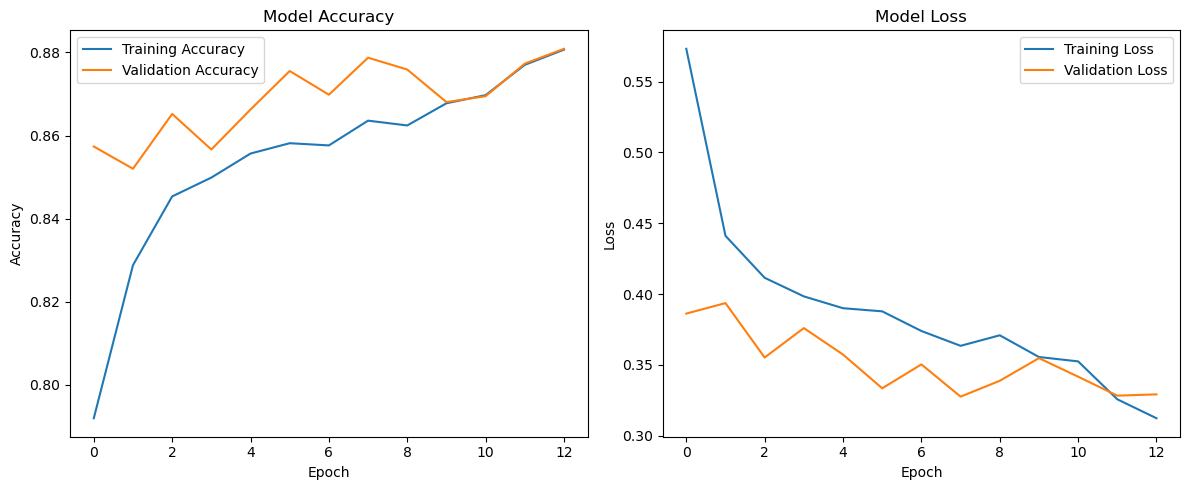

Evaluating model on test data...
94/94 [==============================] - 80s 855ms/step - loss: 0.2710 - accuracy: 0.8987
Test accuracy: 0.8987
Test loss: 0.2710
94/94 [==============================] - 45s 467ms/step

Classification Report:
              precision    recall  f1-score   support

   buildings       0.88      0.92      0.90       437
      forest       0.98      0.99      0.99       474
     glacier       0.83      0.86      0.84       553
    mountain       0.86      0.80      0.83       525
         sea       0.93      0.93      0.93       510
      street       0.92      0.90      0.91       501

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000



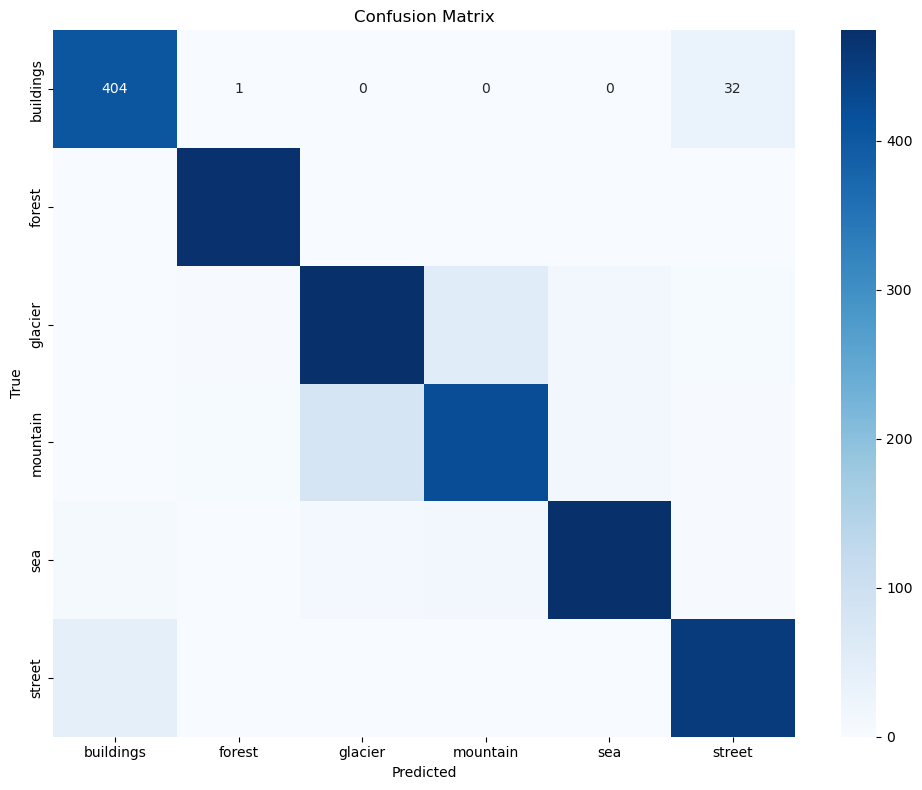

<Figure size 1200x600 with 0 Axes>

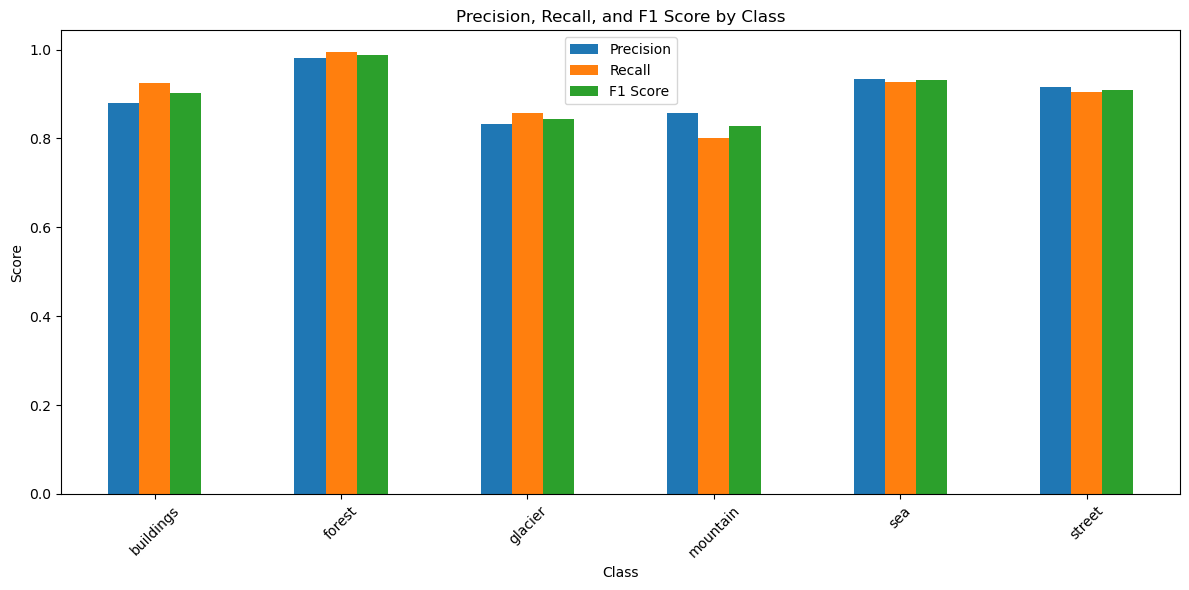

INFO:tensorflow:Assets written to: model_output\saved_models\mobilenet_savedmodel\assets


INFO:tensorflow:Assets written to: model_output\saved_models\mobilenet_savedmodel\assets


Saved artifact at 'model_output\saved_models\mobilenet_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  Args:
    args_0: float32 Tensor, shape=(None, 150, 150, 3)
  Returns:
    float32 Tensor, shape=(None, 6)
Model exported in TensorFlow SavedModel format at model_output\saved_models\mobilenet_savedmodel


C:\Users\Anshif\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved in H5 format at model_output\saved_models\mobilenet_model.h5
Model saved in native Keras format at model_output\saved_models\mobilenet_model.keras
Required packages for ONNX conversion not found. Install with: pip install tf2onnx onnx
ONNX format save skipped.


In [28]:
# MAIN EXECUTION
def main(architecture=MODEL_ARCHITECTURE):
    """Main function to execute the training and evaluation"""
    
    try:
        # Step 1: Get data generators from preprocessing step
        print("Loading data from preprocessing step...")
        
        # Step 2: Build model
        model = build_model(architecture)
        
        # Step 3: Train model
        history = train_model(model, train_generator, validation_generator)

        
        # Step 4: Plot training history
        plot_training_history(history)
        
        # Step 5: Evaluate model
        test_accuracy, y_true, y_pred = evaluate_model(model, test_generator)
        
        # Step 6: Save model
        save_trained_model(model)
        
        
    except Exception as e:
        print(f"Error in model training and evaluation: {e}")

# Execute main function if running this script directly
if __name__ == "__main__":
    main()